In [1]:
# Import libraries
import os
import pandas as pd
import pandas.io.sql as sqlio
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import psycopg2
from dotenv import load_dotenv

# Ignore ipykernel warnings
import warnings
warnings.filterwarnings('ignore')

# Nice looking plots!
sns.set_style('darkgrid')

In [2]:
# Loading database access parameters
load_dotenv()  # take environment variables from .env file
db_user = 'postgres'
db_host = os.getenv('DB_HOST')
db_port = '5432'
db_password = os.getenv('DB_PASS')
db_name = os.getenv('DB_NAME')

# Connecting to database
try:
    connection = psycopg2.connect(
        host = db_host,
        port = db_port,
        database = db_name,
        user = db_user,
        password = db_password
    )
    print('Successfull connection!')
    cursor = connection.cursor()
    cursor.execute('SELECT version()')
    row = cursor.fetchone()
    print(row)
except Exception as e:
    print(e)

Successfull connection!
('PostgreSQL 14.6, compiled by Visual C++ build 1914, 64-bit',)


#### **1. Which product categories have the most sales?**

In [3]:
q1_query = """
WITH product_sales AS (
    SELECT
        product_category_name_english,
        SUM(price) AS sales
    FROM
        benvindo.items AS a
    LEFT JOIN (
        SELECT
            benvindo.products.product_id,
            benvindo.product_category_name_translation.product_category_name_english
        FROM
            benvindo.products
        LEFT JOIN
            benvindo.product_category_name_translation
        ON
            benvindo.products.product_category_name = benvindo.product_category_name_translation.product_category_name
        WHERE
            benvindo.products.product_category_name IS NOT NULL
    ) b
    ON
        a.product_id = b.product_id
    GROUP BY
        product_category_name_english
),
total_sales AS (
    SELECT
        SUM(sales) AS total_price
    FROM
        product_sales
),
sales_pct AS (
    SELECT
        product_category_name_english,
        sales,
        (sales / total_price) * 100 AS sales_percentage
    FROM
        product_sales, total_sales
),
sales_pct_cummulative AS (
    SELECT
        product_category_name_english,
        sales,
        sales_percentage,
        SUM(sales_percentage) OVER (ORDER BY sales_percentage DESC) AS cummulative_sales_percentage
    FROM
        sales_pct
),
abc AS (
    SELECT
        product_category_name_english AS product_category,
        sales,
        sales_percentage,
        cummulative_sales_percentage,
        CASE
        WHEN cummulative_sales_percentage <= 80 THEN 'A'
        WHEN cummulative_sales_percentage > 80 AND cummulative_sales_percentage <= 95 THEN 'B'
        ELSE 'C'
        END AS abc_categories
    FROM
        sales_pct_cummulative
)
SELECT * FROM abc;
"""

In [4]:
q1_df = sqlio.read_sql(q1_query, connection)
q1_df.head()

,product_category,sales,sales_percentage,cummulative_sales_percentage,abc_categories
0,health_beauty,1258681.34,9.260700,9.260700,A
1,watches_gifts,1205005.68,8.865783,18.126483,A
2,bed_bath_table,1036988.68,7.629605,25.756088,A
3,sports_leisure,988048.97,7.269533,33.025621,A
4,computers_accessories,911954.32,6.709669,39.735290,A


In [5]:
# Product categories on A
q1_df[q1_df['abc_categories'] == 'A'][['product_category', 'sales_percentage', 'cummulative_sales_percentage']].sort_values(by='cummulative_sales_percentage')

,product_category,sales_percentage,cummulative_sales_percentage
0,health_beauty,9.260700,9.260700
1,watches_gifts,8.865783,18.126483
2,bed_bath_table,7.629605,25.756088
3,sports_leisure,7.269533,33.025621
4,computers_accessories,6.709669,39.735290
5,furniture_decor,5.369200,45.104489
6,cool_stuff,4.674128,49.778618
7,housewares,4.651745,54.430363
8,auto,4.360916,58.791278
9,garden_tools,3.570256,62.361534


In [6]:
# Product categories on B
q1_df[q1_df['abc_categories'] == 'B'][['product_category', 'sales_percentage', 'cummulative_sales_percentage']].sort_values(by='cummulative_sales_percentage')

,product_category,sales_percentage,cummulative_sales_percentage
17,pet_shop,1.576817,81.213061
18,musical_instruments,1.408946,82.622007
19,small_appliances,1.402690,84.024696
20,None,1.320924,85.345620
21,electronics,1.179009,86.524629
22,consoles_games,1.158544,87.683174
23,fashion_bags_accessories,1.124393,88.807567
24,construction_tools_construction,1.064460,89.872027
25,luggage_accessories,1.033208,90.905235
26,home_appliances_2,0.833731,91.738966


In [7]:
# Product categories on C
q1_df[q1_df['abc_categories'] == 'C'][['product_category', 'sales_percentage', 'cummulative_sales_percentage']].sort_values(by='cummulative_sales_percentage')

,product_category,sales_percentage,cummulative_sales_percentage
33,air_conditioning,0.404844,95.254999
34,audio,0.372939,95.627938
35,small_appliances_home_oven_and_coffee,0.349080,95.977018
36,books_general_interest,0.344748,96.321766
37,kitchen_dining_laundry_garden_furniture,0.340859,96.662625
38,construction_tools_lights,0.302245,96.964869
39,construction_tools_safety,0.298305,97.263174
40,industry_commerce_and_business,0.291868,97.555042
41,food,0.216261,97.771303
42,market_place,0.208794,97.980096


In [8]:
abc_sales_df = q1_df.groupby('abc_categories')['sales'].sum().reset_index()
abc_sales_df

,abc_categories,sales
0,A,10823874.46
1,B,2067820.68
2,C,699948.56


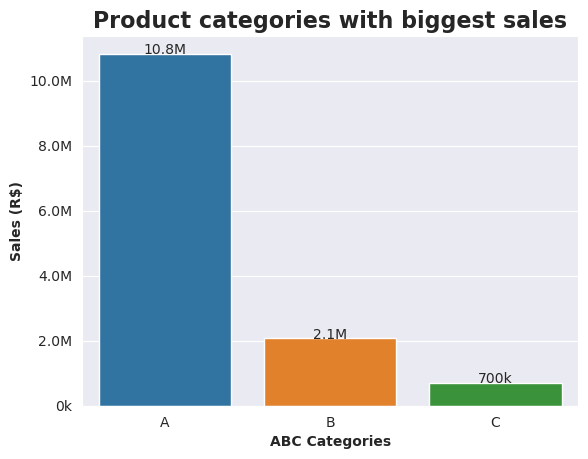

In [9]:
def format_sales(x, pos):
    if x >= 1000000:
        return '{:.1f}M'.format(x * 1e-6)
    else:
        return '{:.0f}k'.format(x * 1e-3)

ax = sns.barplot(data = abc_sales_df,
                 x = 'abc_categories',
                 y = 'sales')

ax.set_title('Product categories with biggest sales', fontsize=16, fontweight='bold')
ax.set_xlabel('ABC Categories', fontweight='bold')
ax.set_ylabel('Sales (R$)', fontweight='bold')

ax.yaxis.set_major_formatter(plt.FuncFormatter(format_sales))

for p in ax.patches:
    sales = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, sales + 1000, format_sales(sales, None), ha='center')

# Display plot
plt.show()

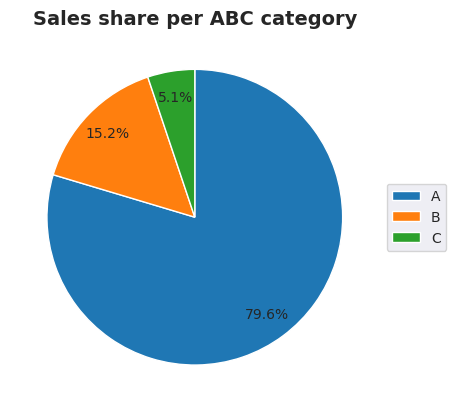

In [10]:
# Create a pie chart
fig, ax = plt.subplots()
wedges, _, autotexts = ax.pie(abc_sales_df['sales'],
                              labels = None,
                              startangle = 90,
                              counterclock = False,
                              autopct = '%1.1f%%',
                              pctdistance = 0.8)

# Format the percentage labels and add them outside the pie chart
for autotext, wedge in zip(autotexts, wedges):
    angle = (wedge.theta2 - wedge.theta1) / 2. + wedge.theta1
    x = wedge.r * 0.82 * np.cos(np.deg2rad(angle))
    y = wedge.r * 0.82 * np.sin(np.deg2rad(angle))
    autotext.set_position((x, y))

# Add legend
legend = ax.legend(abc_sales_df['abc_categories'], loc = 'center left', bbox_to_anchor = (1, 0.5))
ax.set_title('Sales share per ABC category', fontweight='bold', fontsize=14)
plt.show()

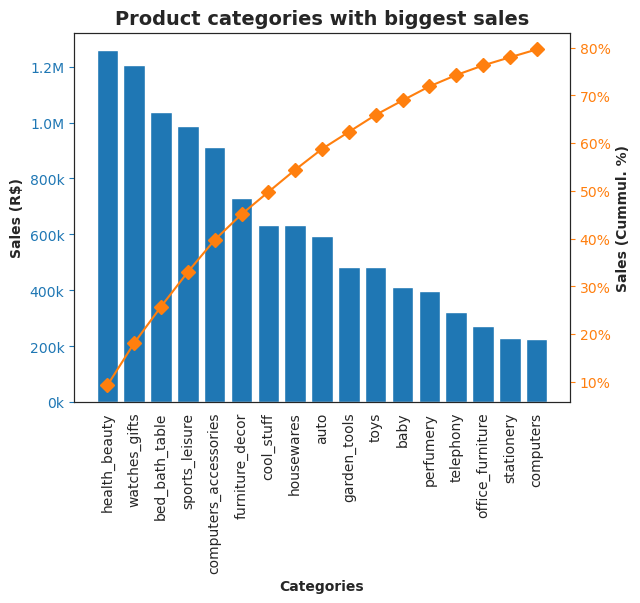

In [11]:
a_cats_df = q1_df[q1_df['abc_categories'] == 'A'][['product_category', 'sales', 'sales_percentage', 'cummulative_sales_percentage']].sort_values(by='cummulative_sales_percentage')

sns.set_style('white')
fig, ax = plt.subplots()

ax.bar(a_cats_df['product_category'], a_cats_df['sales'], color='C0')
ax.set_title('Product categories with biggest sales', fontsize=14, fontweight='bold')
ax.set_xlabel('Categories', fontweight='bold')
ax.set_ylabel('Sales (R$)', fontweight='bold')

ax.yaxis.set_major_formatter(plt.FuncFormatter(format_sales))

ax2 = ax.twinx()
ax2.plot(a_cats_df['product_category'], a_cats_df['cummulative_sales_percentage'], color='C1', marker='D', ms=7)
ax2.set_ylabel('Sales (Cummul. %)', fontweight='bold')
ax2.yaxis.set_major_formatter(ticker.PercentFormatter())

ax.tick_params(axis='x', labelrotation=90)
ax.tick_params(axis='y', colors='C0')
ax2.tick_params(axis='y', colors='C1')

plt.show()

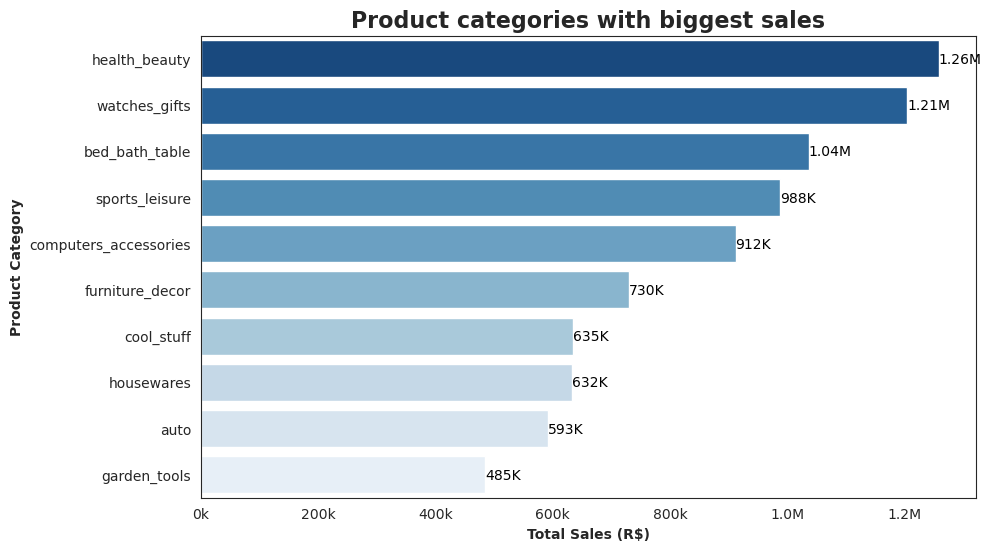

In [12]:
# Adjusting figure size
plt.figure(figsize = (10, 6))

# Horizontal barplot
ax = sns.barplot(data = q1_df[:10],
                 x = 'sales',
                 y = 'product_category',
                 palette='Blues_r')

# Setting title and axis labels
ax.set_title('Product categories with biggest sales', fontsize=16, fontweight='bold')
ax.set_xlabel('Total Sales (R$)', fontweight='bold')
ax.set_ylabel('Product Category', fontweight='bold')

# Formatting x-axis labels
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_sales))

# Adding formatted bar labels
for i, v in enumerate(q1_df['sales'][:10]):
    if v >= 1000000:
        v_str = f'{v/1000000:.2f}M'
    elif v >= 1000:
        v_str = f'{v/1000:.0f}K'
    else:
        v_str = f'{v:.0f}'
    ax.text(v + 0.2, i + 0.1, v_str, color='black')

# Display plot
plt.show()

#### **2. Which product categories have the highest shipping costs?**

In [13]:
q2_query = """
WITH product_costs AS (
    SELECT
        product_category_name_english,
        SUM(a.freight_value) AS total_freight_costs
    FROM
        benvindo.items AS a
    LEFT JOIN (
        SELECT
            benvindo.products.product_id,
            benvindo.product_category_name_translation.product_category_name_english
        FROM
            benvindo.products
        LEFT JOIN
            benvindo.product_category_name_translation
        ON
            benvindo.products.product_category_name = benvindo.product_category_name_translation.product_category_name
        WHERE
            benvindo.products.product_category_name IS NOT NULL
    ) b
    ON
        a.product_id = b.product_id
    GROUP BY
        product_category_name_english
),
total_costs AS (
    SELECT
        SUM(total_freight_costs) AS total_freight
    FROM
        product_costs
),
costs_pct AS (
    SELECT
        product_category_name_english,
        total_freight_costs,
        (total_freight_costs / total_freight) * 100 AS costs_percentage
    FROM
        product_costs, total_costs
),
costs_pct_cummulative AS (
    SELECT
        product_category_name_english,
        total_freight_costs,
        costs_percentage,
        SUM(costs_percentage) OVER (ORDER BY costs_percentage DESC) AS cummulative_costs_percentage
    FROM
        costs_pct
),
abc AS (
    SELECT
        product_category_name_english AS product_category,
        total_freight_costs AS total_costs,
        costs_percentage,
        cummulative_costs_percentage,
        CASE
        WHEN cummulative_costs_percentage <= 80 THEN 'A'
        WHEN cummulative_costs_percentage > 80 AND cummulative_costs_percentage <= 95 THEN 'B'
        ELSE 'C'
        END AS abc_categories
    FROM
        costs_pct_cummulative
)
SELECT * FROM abc;
"""

In [14]:
q2_df = sqlio.read_sql(q2_query, connection)
q2_df.head()

,product_category,total_costs,costs_percentage,cummulative_costs_percentage,abc_categories
0,bed_bath_table,204693.04,9.089754,9.089754,A
1,health_beauty,182566.73,8.107196,17.196951,A
2,furniture_decor,172749.30,7.671236,24.868187,A
3,sports_leisure,168607.51,7.487313,32.355500,A
4,computers_accessories,147318.08,6.541918,38.897418,A


In [15]:
abc_costs_df = q2_df.groupby('abc_categories')['total_costs'].sum().reset_index()
abc_costs_df

,abc_categories,total_costs
0,A,1784864.88
1,B,348227.31
2,C,118817.35


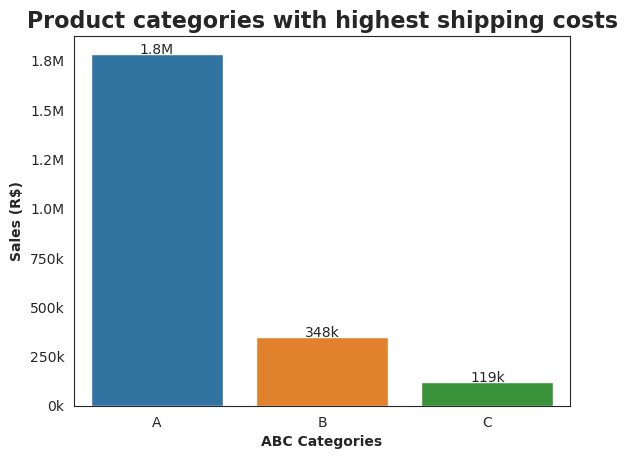

In [16]:
ax = sns.barplot(data = abc_costs_df,
                 x = 'abc_categories',
                 y = 'total_costs')

ax.set_title('Product categories with highest shipping costs', fontsize=16, fontweight='bold')
ax.set_xlabel('ABC Categories', fontweight='bold')
ax.set_ylabel('Sales (R$)', fontweight='bold')

ax.yaxis.set_major_formatter(plt.FuncFormatter(format_sales))

for p in ax.patches:
    sales = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, sales + 1000, format_sales(sales, None), ha='center')

# Display plot
plt.show()

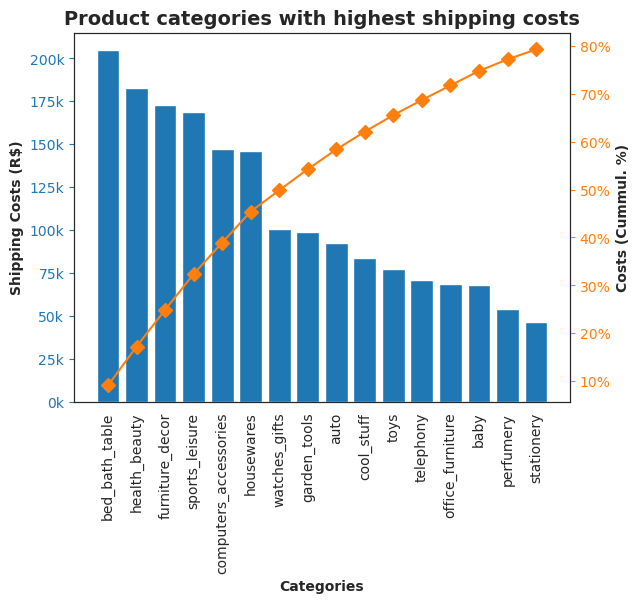

In [17]:
a2_cats_df = q2_df[q2_df['abc_categories'] == 'A'][['product_category', 'total_costs', 'costs_percentage', 'cummulative_costs_percentage']].sort_values(by='cummulative_costs_percentage')

sns.set_style('white')
fig, ax = plt.subplots()

ax.bar(a2_cats_df['product_category'], a2_cats_df['total_costs'], color='C0')
ax.set_title('Product categories with highest shipping costs', fontsize=14, fontweight='bold')
ax.set_xlabel('Categories', fontweight='bold')
ax.set_ylabel('Shipping Costs (R$)', fontweight='bold')

ax.yaxis.set_major_formatter(plt.FuncFormatter(format_sales))

ax2 = ax.twinx()
ax2.plot(a2_cats_df['product_category'], a2_cats_df['cummulative_costs_percentage'], color='C1', marker='D', ms=7)
ax2.set_ylabel('Costs (Cummul. %)', fontweight='bold')
ax2.yaxis.set_major_formatter(ticker.PercentFormatter())

ax.tick_params(axis='x', labelrotation=90)
ax.tick_params(axis='y', colors='C0')
ax2.tick_params(axis='y', colors='C1')

plt.show()

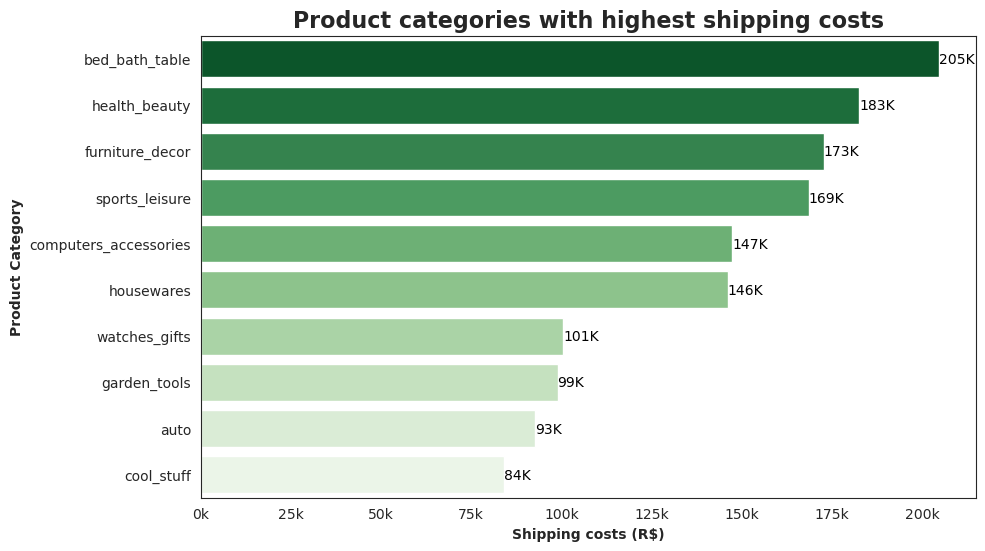

In [18]:
# Adjusting figure size
plt.figure(figsize = (10, 6))

# Horizontal barplot
ax = sns.barplot(data = q2_df[:10],
                 x = 'total_costs',
                 y = 'product_category',
                 palette='Greens_r')

# Setting title and axis labels
ax.set_title('Product categories with highest shipping costs', fontsize=16, fontweight='bold')
ax.set_xlabel('Shipping costs (R$)', fontweight='bold')
ax.set_ylabel('Product Category', fontweight='bold')

# Formatting x-axis labels
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_sales))

# Adding formatted bar labels
for i, v in enumerate(q2_df['total_costs'][:10]):
    if v >= 1000000:
        v_str = f'{v/1000000:.2f}M'
    elif v >= 1000:
        v_str = f'{v/1000:.0f}K'
    else:
        v_str = f'{v:.0f}'
    ax.text(v + 0.2, i + 0.1, v_str, color='black')

# Display plot
plt.show()

#### **3. Which of these categories, considering shipping costs alone, have the highest profit margin?**

In [19]:
merged_df = pd.merge(q1_df, q2_df, on='product_category')
q3_df = merged_df[['product_category', 'sales', 'total_costs']]
q3_df['profit'] = q3_df['sales'] - q3_df['total_costs']
q3_df['profit_margin'] = np.round((q3_df['profit'] / q3_df['sales']) * 100, 4)
q3_df = q3_df.sort_values(by='profit_margin', ascending=False).reset_index(drop=True)
q3_df

,product_category,sales,total_costs,profit,profit_margin
0,computers,224509.08,9969.87,214539.21,95.5593
1,small_appliances_home_oven_and_coffee,47445.71,2747.86,44697.85,94.2084
2,fixed_telephony,59583.00,4637.81,54945.19,92.2162
3,small_appliances_kitchen_and_food_tools,3968.53,309.76,3658.77,92.1946
4,agro_industry_and_commerce,72530.47,5843.60,66686.87,91.9432
...,...,...,...,...,...
68,diapers_and_hygiene,1567.59,573.68,993.91,63.4037
69,christmas_supplies,8800.82,3229.30,5571.52,63.3068
70,furniture_mattress_and_upholstery,4368.08,1630.46,2737.62,62.6733
71,flowers,1110.04,488.87,621.17,55.9592


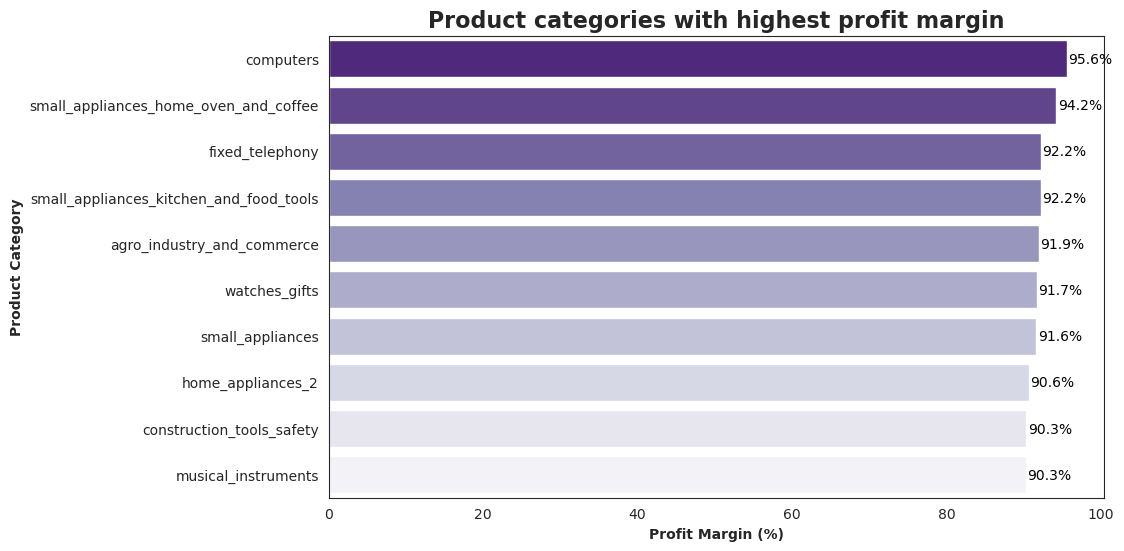

In [20]:
plt.figure(figsize = (10, 6))

ax = sns.barplot(data = q3_df[:10],
                 x = 'profit_margin',
                 y = 'product_category',
                 palette='Purples_r')

ax.set_title('Product categories with highest profit margin', fontsize=16, fontweight='bold')
ax.set_xlabel('Profit Margin (%)', fontweight='bold')
ax.set_ylabel('Product Category', fontweight='bold')

# Formatting x-axis as money values
formatter = ticker.StrMethodFormatter('{x:,.0f}')
ax.xaxis.set_major_formatter(formatter)

# Adding and formatting bar labels
for i, v in enumerate(q3_df['profit_margin'][:10]):
    ax.text(v + 0.2, i + 0.1, f'{v:.1f}%', color='black')

# Display plot
plt.show()

### **4. We think that the products with better reviews are the ones that sell more. Is this really the case?**

In [21]:
q4_query = """
WITH review_analysis AS (
    SELECT a.product_id, AVG(review_score) AS avg_review_score, SUM(price) AS sales
    FROM (
        SELECT r.order_id, r.review_score, i.product_id, i.price
        FROM benvindo.reviews AS r
        LEFT JOIN (
            SELECT order_id, product_id, price
            FROM benvindo.items
        ) AS i
        ON i.order_id = r.order_id
    ) AS a
    GROUP BY a.product_id
    ORDER BY sales
)
SELECT
    CASE
    WHEN avg_review_score >= 1 AND avg_review_score < 2 THEN 1
    WHEN avg_review_score >= 2 AND avg_review_score < 3 THEN 2
    WHEN avg_review_score >= 3 AND avg_review_score < 4 THEN 3
    WHEN avg_review_score >= 4 AND avg_review_score < 5 THEN 4
    ELSE 5
    END AS score_group,
    COUNT(product_id) AS product_count, SUM(sales) AS total_sales
FROM (
    SELECT product_id, avg_review_score, sales
    FROM review_analysis
) AS subquery
GROUP BY score_group
ORDER BY score_group;
"""

In [22]:
q4_df = sqlio.read_sql(q4_query, connection)
q4_df

,score_group,product_count,total_sales
0,1,2842,676171.85
1,2,1579,672504.84
2,3,4916,3135844.19
3,4,9443,6206573.10
4,5,14009,2836130.79


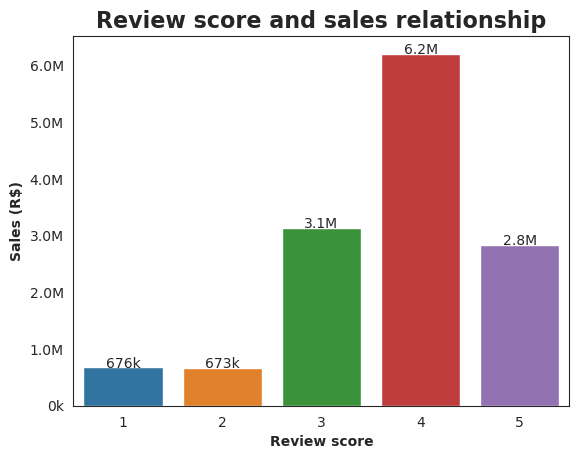

In [23]:
# Creating a function to format sales as "1k" or "1.1M"
def format_sales(x, pos):
    if x >= 1000000:
        return '{:.1f}M'.format(x * 1e-6)
    else:
        return '{:.0f}k'.format(x * 1e-3)

ax = sns.barplot(data = q4_df,
                     x = 'score_group',
                     y = 'total_sales')

ax.set_title('Review score and sales relationship', fontsize=16, fontweight='bold')
ax.set_xlabel('Review score', fontweight='bold')
ax.set_ylabel('Sales (R$)', fontweight='bold')

ax.yaxis.set_major_formatter(plt.FuncFormatter(format_sales))

for p in ax.patches:
    sales = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, sales + 1000, format_sales(sales, None), ha='center')

# Display plot
plt.show()

### **5. What is the customers' preferred payment type? Does it match the payment type with the amount of income?**

In [24]:
q5_query = """
SELECT
    benvindo.payments.payment_type,
    COUNT(benvindo.payments.payment_value) as number_pays,
    ROUND((COUNT(benvindo.payments.payment_value)* 100.0 / (SELECT COUNT(*) FROM benvindo.payments)), 2) as percentage,
    SUM(benvindo.payments.payment_value) as pays
FROM
    benvindo.payments
WHERE
    benvindo.payments.payment_type <> 'not_defined'
GROUP BY
    benvindo.payments.payment_type
ORDER BY
    percentage DESC;
"""

In [25]:
q5_df = sqlio.read_sql(q5_query, connection)
q5_df

,payment_type,number_pays,percentage,pays
0,credit_card,76795,73.92,12542084.19
1,boleto,19784,19.04,2869361.27
2,voucher,5775,5.56,379436.87
3,debit_card,1529,1.47,217989.79


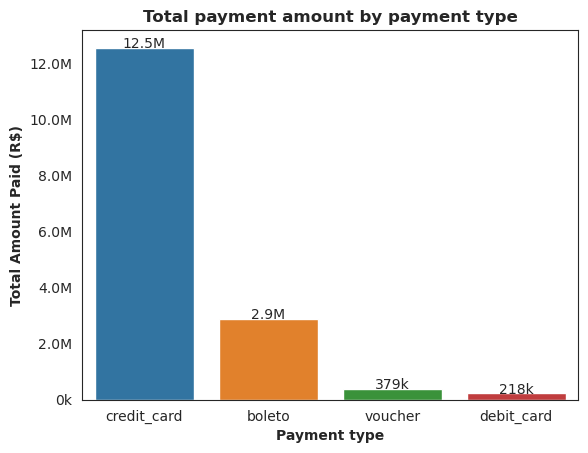

In [26]:
ax = sns.barplot(data = q5_df,
                 x = 'payment_type',
                 y = 'pays')

ax.set_title('Total payment amount by payment type', fontweight='bold')
ax.set_xlabel('Payment type', fontweight='bold')
ax.set_ylabel('Total Amount Paid (R$)', fontweight='bold')

ax.yaxis.set_major_formatter(plt.FuncFormatter(format_sales))

for p in ax.patches:
    sales = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, sales + 1000, format_sales(sales, None), ha='center')

# Display plot
plt.show()

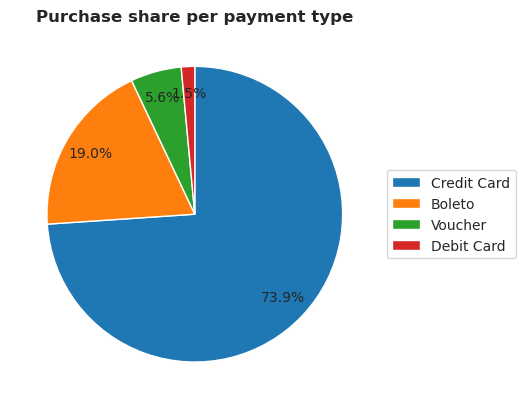

In [27]:
# Format payment types
q5_df['payment_type'] = q5_df['payment_type'].str.title().str.replace('_', ' ')

# Create a pie chart
fig, ax = plt.subplots()
wedges, _, autotexts = ax.pie(q5_df['percentage'],
                              labels = None,
                              startangle = 90,
                              counterclock = False,
                              autopct = '%1.1f%%',
                              pctdistance = 0.8)

# Format the percentage labels and add them outside the pie chart
for autotext, wedge in zip(autotexts, wedges):
    angle = (wedge.theta2 - wedge.theta1) / 2. + wedge.theta1
    x = wedge.r * 0.82 * np.cos(np.deg2rad(angle))
    y = wedge.r * 0.82 * np.sin(np.deg2rad(angle))
    autotext.set_position((x, y))

# Add legend
legend = ax.legend(q5_df['payment_type'], loc = 'center left', bbox_to_anchor = (1, 0.5))
ax.set_title('Purchase share per payment type', fontweight='bold')
plt.show()